In [4]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random
from sklearn.model_selection import train_test_split
import csv
from data.create_dataset import create_dataset
from data.load import load_dataset, load_dataset_kfold
import seaborn as sns

from collections import deque
import json

def exhaust(generator):
    deque(generator, maxlen=0)

import warnings
warnings.filterwarnings("ignore")

br_types = ['mdamb231', 'mcf7']
cell_types = sorted(['hela', 'preo', 'lclc', 'mdamb231', 'mcf7', 'breastcancer'])
SRC_PATH = 'data_paths.txt'
DEST_PATH = '/media/balint/Backup1/data/1d-class-datasets/interpolated-7th-run/'
datasets = ["hela-mcf7-mdamb231", "hela-lclc-preo-mcf7-mdamb231", "mcf7-mdamb231", "hela-lclc-mcf7-mdamb231", "breastcancer-hela-lclc", "breastcancer-hela-lclc-preo", "breastcancer-hela"]
# datasets = ["hela-lclc-preo-mcf7-mdamb231","breastcancer-hela-lclc-preo"]
datasets = ['-'.join(sorted(ds.split('-'))) for ds in datasets]
times = [30, 60, 90, 120, 150]

def get_idx(tp):
    for i, t in enumerate(cell_types):
        if tp == t:
            return i
    return -1

datasets

['hela-mcf7-mdamb231',
 'hela-lclc-mcf7-mdamb231-preo',
 'mcf7-mdamb231',
 'hela-lclc-mcf7-mdamb231',
 'breastcancer-hela-lclc',
 'breastcancer-hela-lclc-preo',
 'breastcancer-hela']

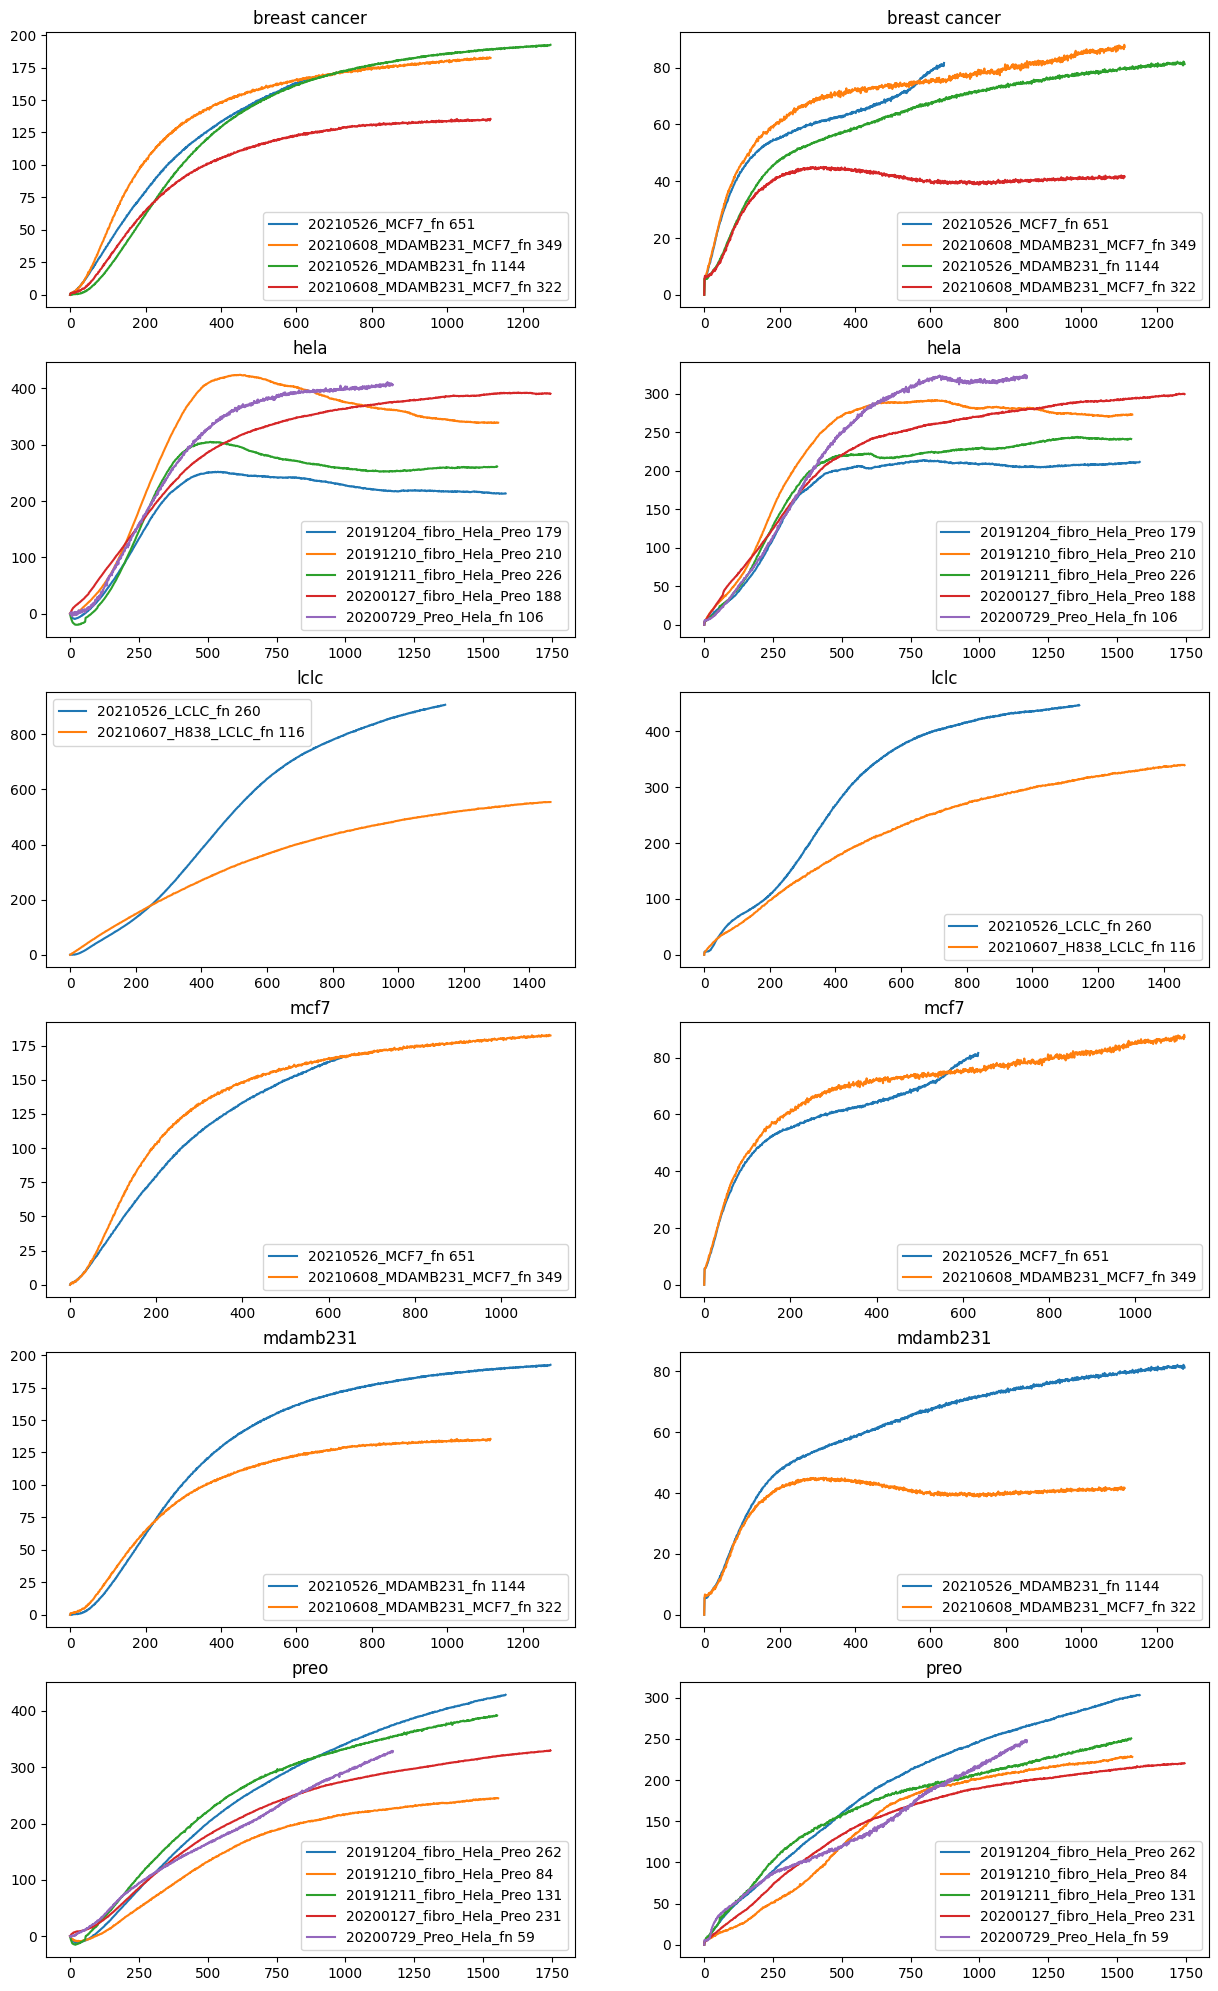

In [5]:
if not os.path.exists(DEST_PATH):
    os.makedirs(DEST_PATH)
fig, ax = plt.subplots(len(cell_types),2, figsize=(15,25))
meas_counts = {t: [] for t in cell_types}
for tp in cell_types:
    with open(SRC_PATH, 'r') as fp:
        for file_path in fp.readlines():
            file_path = file_path.strip()
            
            if tp != file_path.split('/')[-1].split('_')[0].lower():
                continue
                
            # print(file_path, tp, os.path.exists(file_path))
            res_max_path = os.path.join(DEST_PATH, f'{tp}_max_signals.csv')
            lines = pd.read_csv(file_path, header=None)
            time = np.round(np.array(lines.iloc[0, :]), 0).astype(int)
            signals = np.array(lines.iloc[1:, :])
            
            # print(signals.shape)
            
            d = []
            for i in range(signals.shape[0]):
                if np.min(signals[i]) <= -100 or np.max(signals[i, :int(max(times) * 60 / 9)]) <= 100:
                    d.append(i)
            
            signals = np.delete(signals, d, axis=0)
            
            diff = np.diff(np.mean(signals, axis=0))
            err = np.argwhere(np.logical_or(diff > 5, diff < -5))
            err = err.reshape((-1,))
            err.sort()
            peaks = np.argwhere(np.diff(err) == 1)
            peaks = peaks.reshape((-1, ))
            err = np.unique(np.concatenate([err[peaks], err[peaks + 1]]))
            data_range = np.arange(signals.shape[1])
            org = data_range.copy()
            data_range = np.delete(data_range, err, axis=0)
            
            data = signals
        
            time_avg_max = np.round(np.mean(np.diff(time)), 0)
            
            new_data = np.zeros(data.shape)
            data = np.delete(data, err, axis=1)
            for i in range(new_data.shape[0]):
                new_data[i] = np.interp(org, data_range, data[i])
            data = new_data

            interpolate = False
            if time_avg_max == 12:
                interpolate = True
                new_time = np.round(np.linspace(0,max(time), int(max(time) / 3)),0).astype(int)
                new_time_red = np.interp(new_time, time, time)[:None:3]
                
            if interpolate:
                # print(f'Interpolating {file_path}')
                new_data = np.zeros((data.shape[0], new_time_red.shape[0]))
                for i in range(data.shape[0]):
                    new_data[i] = np.interp(new_time_red, time, data[i])
                data = new_data
                
            for i in range(data.shape[0]):
                data[i] -= data[i, 0]

            pd.DataFrame(data[:, :int(max(times) * 60 / 9)]).to_csv(res_max_path, mode='a', header=None, index=None)
            
            meas_counts[tp].append(file_path.split('/')[-3] +  f' ({str(data.shape[0])})')
            
            i = get_idx(tp)
            
            ax[i, 0].set_title(tp)
            ax[i, 1].set_title(tp)
            ax[i, 0].plot(np.mean(data, axis=0), label=file_path.split('/')[-3] +  ' ' + str(data.shape[0]))
            ax[i, 1].plot(np.std(data, axis=0), label=file_path.split('/')[-3] +  ' ' + str(data.shape[0]))
            ax[i, 0].legend()
            ax[i, 1].legend()
                
                            
            if tp in br_types:
                pd.DataFrame(data[:, :int(max(times) * 60 / 9)]).to_csv(os.path.join(DEST_PATH, f'breastcancer_max_signals.csv'), mode='a', header=None, index=None)
                i = get_idx('breastcancer')
                ax[i, 0].set_title('breast cancer')
                ax[i, 1].set_title('breast cancer')
                ax[i, 0].plot(np.mean(data, axis=0), label=file_path.split('/')[-3] +  ' ' + str(data.shape[0]))
                ax[i, 1].plot(np.std(data, axis=0), label=file_path.split('/')[-3] +  ' ' + str(data.shape[0]))
                ax[i, 0].legend()
                ax[i, 1].legend()         
                meas_counts['breastcancer'].append(file_path.split('/')[-3] +  f' ({str(data.shape[0])})')
            
plt.savefig(os.path.join(DEST_PATH, f'processed-signals.png'), dpi=300)

with open(os.path.join(DEST_PATH, 'measurement_stats.json'), 'w') as fp:
    json.dump(meas_counts, 
              fp, 
              sort_keys=False,
              indent=4,
              separators=(',', ': ')
              )

In [6]:
for ds in datasets:
    exhaust(create_dataset(DEST_PATH, os.path.join(DEST_PATH, ds), ds.split('-'), [int(t * 60 / 9) for t in [30, 60, 90, 120, 150]], .2))

[909, 1000, 1466]
Counter({2: 1172, 1: 800, 0: 727}) Counter({2: 294, 1: 200, 0: 182})
Counter({2: 1172, 1: 800, 0: 727}) Counter({2: 294, 1: 200, 0: 182})
Counter({2: 1172, 1: 800, 0: 727}) Counter({2: 294, 1: 200, 0: 182})
[909, 349, 1466]
Counter({2: 1172, 0: 727, 1: 279}) Counter({2: 294, 0: 182, 1: 70})
Counter({2: 1172, 0: 727, 1: 279}) Counter({2: 294, 0: 182, 1: 70})
[909, 376, 1000, 1466, 767]
Counter({3: 1172, 2: 800, 0: 727, 4: 613, 1: 300}) Counter({3: 294, 2: 200, 0: 182, 4: 154, 1: 76})
Counter({3: 1172, 2: 800, 0: 727, 4: 613, 1: 300}) Counter({3: 294, 2: 200, 0: 182, 4: 154, 1: 76})
Counter({3: 1172, 2: 800, 0: 727, 4: 613, 1: 300}) Counter({3: 294, 2: 200, 0: 182, 4: 154, 1: 76})
[909, 376, 349, 1466, 767]
Counter({3: 1172, 0: 727, 4: 613, 1: 300, 2: 279}) Counter({3: 294, 0: 182, 4: 154, 1: 76, 2: 70})
Counter({3: 1172, 0: 727, 4: 613, 1: 300, 2: 279}) Counter({3: 294, 0: 182, 4: 154, 1: 76, 2: 70})
[1000, 1466]
Counter({1: 1172, 0: 800}) Counter({1: 294, 0: 200})
Cou

In [ ]:
# for t in times:
#     ln = int(t * 60 / 9)
for t in times:
    # plt.figure()
    fig, ax = plt.subplots(len(cell_types),1, figsize=(10,10))
    for n, tp in enumerate(cell_types):
        res_max_path = os.path.join(DEST_PATH, f'{tp}_max_signals.csv')
        if os.path.exists(res_max_path):
            data = []
            fp = open(res_max_path, 'r')
            reader = csv.reader(fp)
            for line in reader:
                # print(line)
                line = list(filter(lambda a: a != '', line))
                if len(line) >= int(t * 60 / 9):
                    line = list(map(float, line))[:int(t * 60 / 9)]
                    ax[n].plot(line)
                    data.append(line)
            data = np.asarray(data)
            # print(tp, data.shape)
            # print(np.min(data[:, -1]), np.max(data[:, -1]))
            # plt.plot(np.mean(data, axis=0), label=tp)
    plt.legend()
    plt.show()


In [ ]:
# for i, t in enumerate(times):
#     for ds in datasets:
#         if not os.path.exists(os.path.join(DEST_PATH, str(t), ds)):
#             os.makedirs(os.path.join(DEST_PATH, str(t), ds))
#         typs = sorted(ds.split('-'))
#         labels = list(range(len(typs)))
#         data = []
#         for tp in typs:
#             res_max_path = os.path.join(DEST_PATH, f'{tp}_max_signals.csv')
#             if os.path.exists(res_max_path):
#                 fp = open(res_max_path, 'r')
#                 reader = csv.reader(fp)
#                 for line in reader:
#                     if len(line) >= ln:
#                         line = list(map(float, line))[:ln]
#                         data.append(line)
#         data = np.asarray(data)
        
#         pd.DataFrame(list(zip(typs, labels)), columns=['type', 'tag']).to_csv(os.path.join(DEST_PATH, str(t), ds, 'dictionary.csv'), index=None)

In [ ]:
X_train, y_train, X_test, y_test, tag_conv = load_dataset(os.path.join(DEST_PATH, datasets[0], str(120)), scale=False)
X_train2, y_train2, _, _, _ = load_dataset(os.path.join(DEST_PATH, datasets[0], str(120)), resample=False, scale=False)
y_train.shape, y_train2.shape

In [ ]:
X_train.shape, y_train.shape, X_test.shape

In [ ]:
np.unique(y_train, return_counts=True), np.unique(y_train2, return_counts=True), np.unique(y_test, return_counts=True)

In [ ]:
for i in np.unique(y_train):
    fig, ax = plt.subplots(1,1)
    d = X_train[y_train == i]
    d2 = X_train2[y_train2.squeeze() == i]
    print(d.shape, d2.shape)
    sns.distplot(d[:,-1], ax=ax)
    sns.distplot(d2[:,-1], ax=ax)
    plt.show()

In [ ]:
stats = []
data_loader = list(load_dataset_kfold(os.path.join(DEST_PATH, datasets[0], str(120)), resample=False, scale=False))
for _ in range(5):
    for X_train, y_train, X_test, y_test, tag_conv, scaler in data_loader:
        for i in np.unique(y_train):
            # fig, ax = plt.subplots(1,1)
            # d = X_data[y_data.squeeze() == i]
            # d2 = X_train[y_train.squeeze() == i]
            # d3 = X_test[y_test.squeeze() == i]
            # print(tag_conv[0][i], d.shape, d2.shape, d3.shape, [np.mean(d[:, -1]) for d in [d, d2, d3]])
            # sns.distplot(d[:,-1], ax=ax, label='data')
            # sns.distplot(d2[:,-1], ax=ax, label='train')
            # sns.distplot(d3[:,-1], ax=ax, label='test')
            # plt.legend()
            # plt.show()
            stats.append((_, tag_conv[0][i], np.mean(X_train[y_train.squeeze() == i]), np.mean(X_test[y_test.squeeze() == i])))

for line in stats:
    print(line)